In [11]:
from model import *

import sys
#!{sys.executable} -m pip install [arg]

import time
import random
import numpy as np
import networkx as nx

from itertools import product

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

# 1) Construct network

In [2]:
def build_graph(n=100, m=3, p=0.5):
    G = nx.powerlaw_cluster_graph(n=n, m=m, p=p) 
    assert nx.is_connected(G)
    return G


def get_adjacency(G):
    return dict((n, set(nbrdict.keys())) for n, nbrdict in G.adjacency())

# 2) Define groups

In [3]:
def get_communities(G):
    return list(nx.community.label_propagation_communities(G))
 

def get_node_community_map(communities):
    node_community_map = {}
    for i,c in enumerate(communities):
        for node in c:
            node_community_map[node] = i
    return node_community_map


def get_community_membership(adjacency, node_community_map):
    membership = {i:set() for i in node_community_map}
    for i, neighbours in adjacency.items():
        for n in neighbours:
            membership[i].add(node_community_map[n])
        membership[i].add(node_community_map[i])
    membership = {k:list(v) for k,v in membership.items()}
    return membership

# 3) Generate projects

In [4]:
def generate_projects(N, left_0=0.5, right_0=0.8, left_1=1.6, right_1=3.2):
    """
    Generate N gambles with 2 outcomes.
    """
    assert (left_0+left_1) / 2 > 1
    
    left  = np.random.uniform(left_0, right_0, N)
    right = np.random.uniform(left_1, right_1, N)
    projects = {i:(left[i],right[i]) for i in range(N)}
                
    return projects


def get_project_return(P):
    return np.random.choice([P[0], P[1]])

In [5]:
def generate_gambles(N):
    """
    Generate N gambles with 2 outcomes.
    """
    probs1   = np.random.uniform(0.2, 0.8, N)
    probs2   = 1 - probs1
    
    outcomes1 = np.random.uniform(0.9, 0.95, N)
    outcomes2 = np.random.uniform(1.5, 2.0, N)
        
    gambles = []
    for i in range(N):
        gambles.append({
            "outcomes" : [outcomes1[i],outcomes2[i]],
            "probs"    : [probs1[i],probs2[i]]
        })
    return gambles


def get_gamble_return(P):
    return np.random.choice(P["outcomes"], p=P["probs"])

# 4) Maximize expected utility

In [6]:
def utility(x, w, project_realizations, project_probs, A, gamma):
    """
    Compute expected utility.
    Args:
        x : (3,) array containing [consumption_proportion, risky_invest_proportion, safe_invest_proportion]
        w : wealth level of agent
        project_realizations : cartesian product of possible project realizations
        project_probs : probabilities associated with the project realizations
        A : utility function parameter
        gamma : utility function parameter
    Returns:
        best utility
    """
    # utility from consumption
    c_prop = x[0]
    consumption_utility = U(w*c_prop, A=A, gamma=gamma)
        
    # other params
    s_prop = x[1]
    risky_props = x[2:]

    project_utility = 0
    for i, row in enumerate(project_realizations):
        project_utility += project_probs[i] * V(w*s_prop + sum(w*row*risky_props))
    
    return - (consumption_utility + project_utility)

# 5) Simulation

In [31]:
def simulation(NUM_AGENTS=500, STEPS=1, SAFE_RETURN=1.1, DEFAULT_A=1.2, 
               PROJECT_COST=3.0, W0=0.8, W1=1.2, G0=0.5, G1=3.0, graph=None):
    """
    Run ABM
    Args:
        NUM_AGENTS   : number of agents
        STEPS        : number of steps
        SAFE_RETURN  : safe return coefficient (> 1.0)
        DEFAULT_A    : parameter used in utility functions
        PROJECT_COST : minimum cost for project to be undertaken
        W0           : left bound for uniform random wealth initialization
        W1           : right bound for uniform random wealth initialization
        G0           : left bound for uniform random gamma initialization
        G1           : right bound for uniform random gamma initialization
    Returns:
        WEALTH      : (STEPS, NUM_AGENTS) array containing wealth levels of agents at each iteration
        communities : dict from community ID to list of members
    """
    
    # construct graph and adjacency matrix
    G = graph or build_graph(n=NUM_AGENTS, m=2)
    adjacency = get_adjacency(G)
    
    # extract communities
    communities = get_communities(G)
    print(f"{len(communities)} communities.")
    
    # get community membership of nodes
    node_community_map = get_node_community_map(communities)
    community_membership = get_community_membership(adjacency, node_community_map)
    communities = {c:[] for c in range(len(communities))}
    for i, comms in community_membership.items():
        for c in comms:
            communities[c].append(i)

    # optimization constraint
    cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)})
    
    # global attributes
    GAMBLES = generate_gambles(len(communities))
    PID      = np.zeros((NUM_AGENTS), dtype=int)
    
    # agent attributes
    WEALTH = np.random.uniform(W0, W1, (STEPS+1, NUM_AGENTS))
    GAMMAS = np.random.uniform(G0, G1, NUM_AGENTS)
    C = np.zeros((NUM_AGENTS))
    
    
    R = np.zeros((NUM_AGENTS))
    S = np.zeros((NUM_AGENTS))    
    
    AGENT_PROJECTS = []
    PROJECT_REALIZATIONS = []
    PROJECT_PROBS = []
    X0 = []
    BOUNDS = []
    PARAMS = {}
    
    for i in range(NUM_AGENTS):
        
        AGENT_PROJECTS.append([GAMBLES[c] for c in community_membership[i]])
        PROJECT_REALIZATIONS.append(np.array(list(product(*[p["outcomes"] for p in AGENT_PROJECTS[i]]))))
        PROJECT_PROBS.append(np.prod(np.array(list(product(*[p["probs"] for p in AGENT_PROJECTS[i]]))), axis=1))
        num_params = 2 + len(AGENT_PROJECTS[i])
        X0.append([[1/num_params] * num_params])
        BOUNDS.append((((0.0,1.0),) * num_params))
    
    
    # metrics
    # TODO...
    
    
    # simulation
    
    for step in tqdm(range(STEPS)):

        project_contributions = np.zeros((len(GAMBLES)))

        # all agents perform optimization step and we sum up project contributions
        for i in range(NUM_AGENTS):
            
            params = minimize(utility, x0=X0[i], bounds=BOUNDS[i], constraints=cons, 
                              args=(WEALTH[step][i], PROJECT_REALIZATIONS[i], 
                                    PROJECT_PROBS[i], DEFAULT_A, GAMMAS[i]), 
                              method='SLSQP').x
            
            # store consumption
            C[i] = params[0]
            S[i] = params[1]
            
            # add contribution to project development
            PARAMS[i] = params[2:]
            for idx, p in enumerate(params[2:]):
                project_contributions[community_membership[i][idx]] += WEALTH[step][i]*params[2:][idx]
            
        # run projects
        risky_returns = np.zeros((len(GAMBLES)))
        for idx, P in enumerate(GAMBLES):
            if project_contributions[idx] >= PROJECT_COST:
                risky_returns[idx] = get_gamble_return(P)

    
        for i in range(NUM_AGENTS):
            WEALTH[step+1][i] = WEALTH[step][i] - sum(WEALTH[step][i] * PARAMS[i]) + \
                                sum(WEALTH[step][i] * PARAMS[i] * [risky_returns[p] 
                                                                   for p in community_membership[i]]) + \
                                WEALTH[step][i]*S[i] - WEALTH[step][i]*C[i]

        
    return WEALTH, communities, PARAMS

In [32]:
def count_crossover_points(W, communities=None):
    """
    Count number of crossover points at agent or community level.
    Args:
        W           : (STEPS, NUM_AGENTS) array
        communities : dict from community ID to list of members (community level if this is provided)
    Returns:
        number of crossover points.
    """
    # communities is specified, so count crossover points at community-level
    if communities:
        crossover_points = {c:0 for c in range(len(communities))}
        for c, agent_list in communities.items():
            trajectory = np.mean(W[:,agent_list], axis=1)
            for i in range(len(trajectory)-2):
                if (trajectory[i+1] - trajectory[i] > 0 and trajectory[i+2] - trajectory[i+1] < 0) or \
                   (trajectory[i+1] - trajectory[i] < 0 and trajectory[i+2] - trajectory[i+1] > 0):
                        crossover_points[c] += 1

    # otherwise count at agent level
    else:
        num_agents = W.shape[1]
        crossover_points = {a:0 for a in range(num_agents)}
        for a in range(num_agents):
            trajectory = W[:,a]
            for i in range(len(trajectory)-2):
                if (trajectory[i+1] - trajectory[i] > 0 and trajectory[i+2] - trajectory[i+1] < 0) or \
                   (trajectory[i+1] - trajectory[i] < 0 and trajectory[i+2] - trajectory[i+1] > 0):
                        crossover_points[a] += 1
                    
    return crossover_points

In [33]:
W, communities, P = simulation(NUM_AGENTS=100, STEPS=20, PROJECT_COST=0.5)

17 communities.


100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


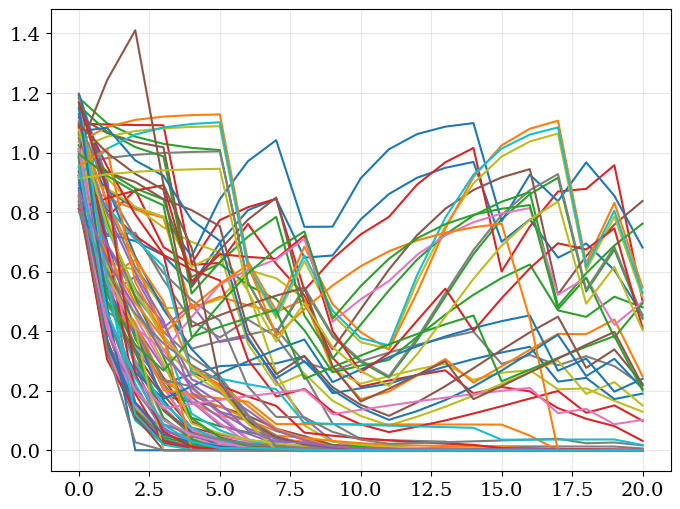

In [34]:
for i in range(W.shape[1]):
    plt.plot(W[:,i])t

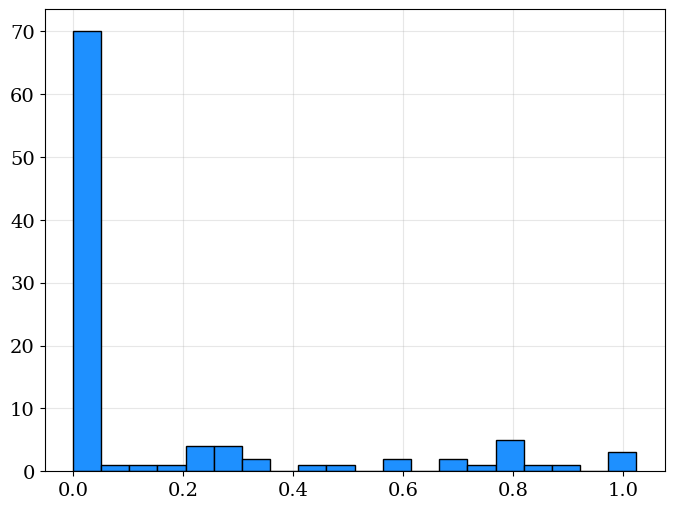

In [68]:
plt.hist(W[15], color="dodgerblue", edgecolor="k", bins=20)
plt.show()

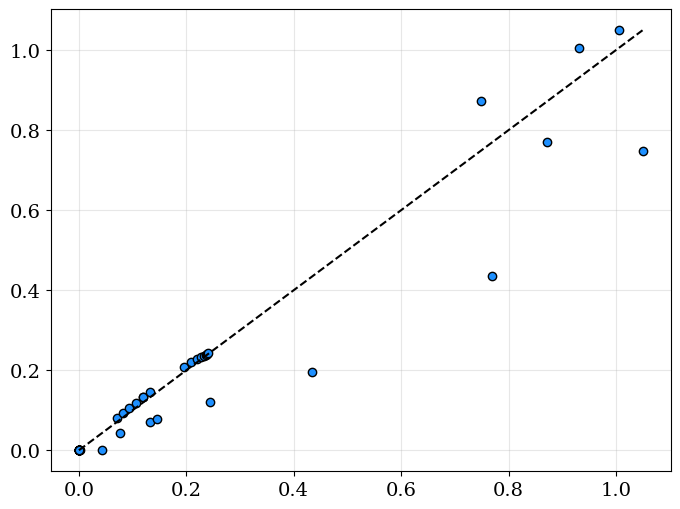

In [23]:
i = 7

x=[]
y=[]
for k in range(len(W)-1):
    x.append(W[k][i])
    y.append(W[k+1][i])
    
plt.scatter(x,y, color="dodgerblue", edgecolor="k")
plt.plot(np.linspace(min(x), max(x), 100), np.linspace(min(x), max(x), 100), color="k", linestyle="dashed")
plt.show()